# Phase 1: Data Acquisition, Data Preparation & Exploratory Data Analysis
## Data Acquisition:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import re


# get columns names froms names file
#location of names
http = 'https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.names'
#request to ge raw data
req = requests.request('get',url = http)
#search to match columns
search = re.compile('[0-9]{1,2}. ([-?\w]+):')
#finding based on search droping some extra data
names = search.findall(req.text)[3:]
#inserting poisonous which was not listed in atribute list
names.insert(0,'poisonous')

#created Data frame with data plus names dirived above
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data',names = names)
df.head()

,poisonous,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


## Data Prep
###  creating Subset

In [2]:
# selecting collumns
columns = ['poisonous','odor','bruises?', 'spore-print-color']
#creating subset
df_for_pred = df.loc[:,columns]

### null check

In [3]:
df_for_pred.isnull().sum()

poisonous            0
odor                 0
bruises?             0
spore-print-color    0
dtype: int64

### Initial Visualizing

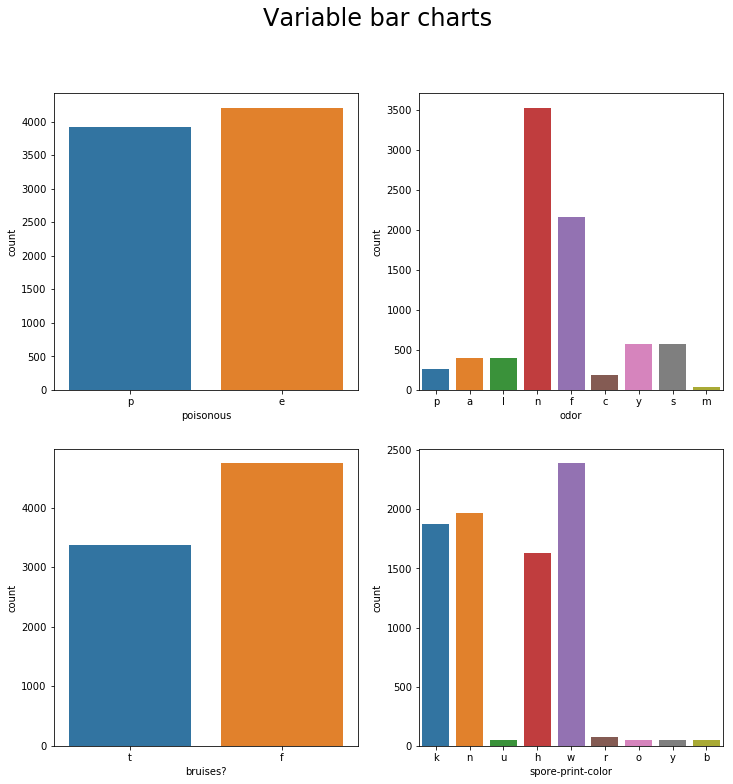

In [4]:
# EDA of selected variable 
plt.figure(figsize=(12,12));
plt.suptitle('Variable bar charts',fontsize=24)
#plt.tight_layout();
plt.subplot(2,2,1);
sns.countplot(x='poisonous', data = df_for_pred);
plt.subplot(2,2,2);
sns.countplot(x='odor', data=df_for_pred);
plt.subplot(2,2,3);
sns.countplot(x='bruises?', data=df_for_pred);
plt.subplot(2,2,4);
sns.countplot(x='spore-print-color',data=df_for_pred);

# counts

In [5]:
display(df_for_pred.odor.value_counts()) 

n    3528
f    2160
y     576
s     576
l     400
a     400
p     256
c     192
m      36
Name: odor, dtype: int64

In [6]:
display(df_for_pred['spore-print-color'].value_counts())

w    2388
n    1968
k    1872
h    1632
r      72
y      48
b      48
o      48
u      48
Name: spore-print-color, dtype: int64

# combining sparse classes
## spore print color

In [7]:
df_for_pred.loc[
    df_for_pred['spore-print-color'].isin(['r','u','b','o','y']),
    'spore-print-color'] = 'other'
display(df_for_pred['spore-print-color'].value_counts())

w        2388
n        1968
k        1872
h        1632
other     264
Name: spore-print-color, dtype: int64

# setting Binary variables and dummy variables

## Poisonous

In [8]:
df_for_pred.poisonous = (df_for_pred.poisonous == 'p').astype(int)
df_for_pred.poisonous.value_counts()

0    4208
1    3916
Name: poisonous, dtype: int64

## bruises?

In [9]:
df_for_pred['bruises?'] = (df_for_pred['bruises?'] =='t').astype(int)

df_for_pred['bruises?'].value_counts()

0    4748
1    3376
Name: bruises?, dtype: int64

## Get Dummies

In [10]:
df_with_dummies = pd.get_dummies(df_for_pred)
df_with_dummies.head()
df_with_dummies.groupby('poisonous').mean()

,bruises?,odor_a,odor_c,odor_f,odor_l,odor_m,odor_n,odor_p,odor_s,odor_y,spore-print-color_h,spore-print-color_k,spore-print-color_n,spore-print-color_other,spore-print-color_w
poisonous,,,,,,,,,,,,,,,
0,0.653992,0.095057,0.00000,0.000000,0.095057,0.000000,0.809886,0.000000,0.000000,0.000000,0.011407,0.391635,0.414449,0.045627,0.136882
1,0.159346,0.000000,0.04903,0.551583,0.000000,0.009193,0.030644,0.065373,0.147089,0.147089,0.404494,0.057201,0.057201,0.018386,0.462717


# EDA
 ## 1. odor
 ## 2. spore-print-color
 ## 3. bruises?

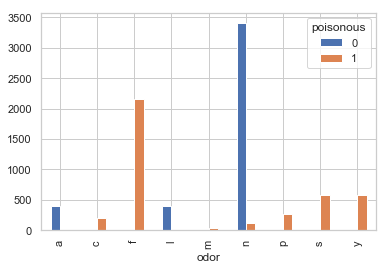

<Figure size 432x288 with 0 Axes>

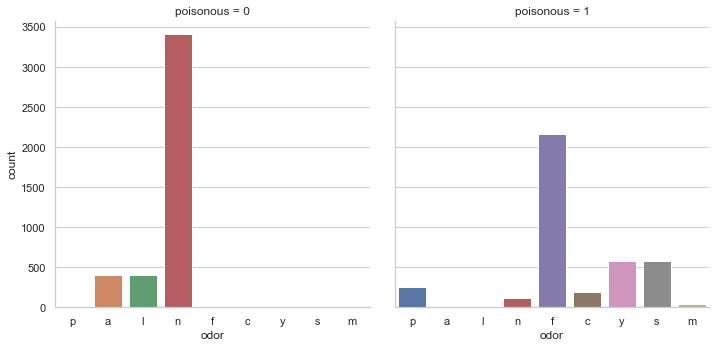

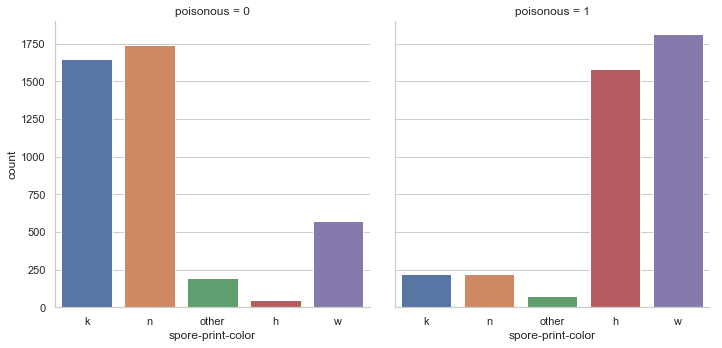

In [59]:
plt.figure();
sns.catplot(data=df_for_pred,x='odor',kind='count',col='poisonous');
sns.catplot(data=df_for_pred,x='spore-print-color',kind='count',col='poisonous');a

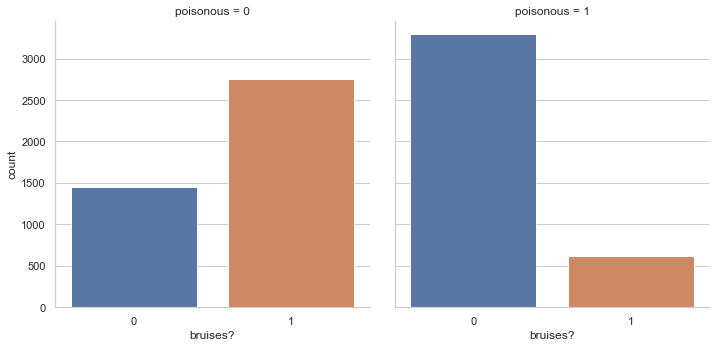

In [56]:
sns.catplot('bruises?',col ='poisonous',kind='count',data=df_for_pred);

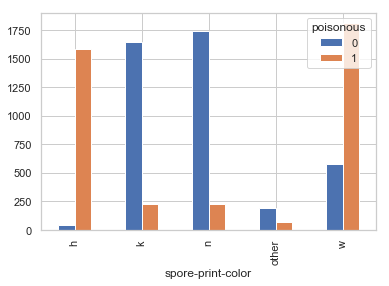

In [109]:
#sns.barplot(data = pd.crosstab(df_for_pred['spore-print-color'],df_for_pred.poisonous).reset_index(),x='spore-print-color');
pd.crosstab(df_for_pred['spore-print-color'],df_for_pred.poisonous).plot.bar();           

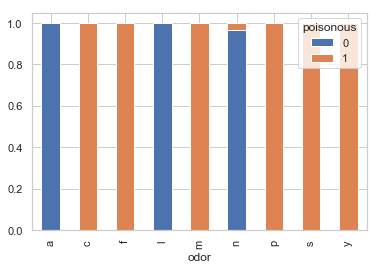

In [96]:
table = pd.crosstab(df_for_pred.odor,df_for_pred.poisonous)
table.div(table.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True);
 

Odor Appears to be a good predictor of posionousness

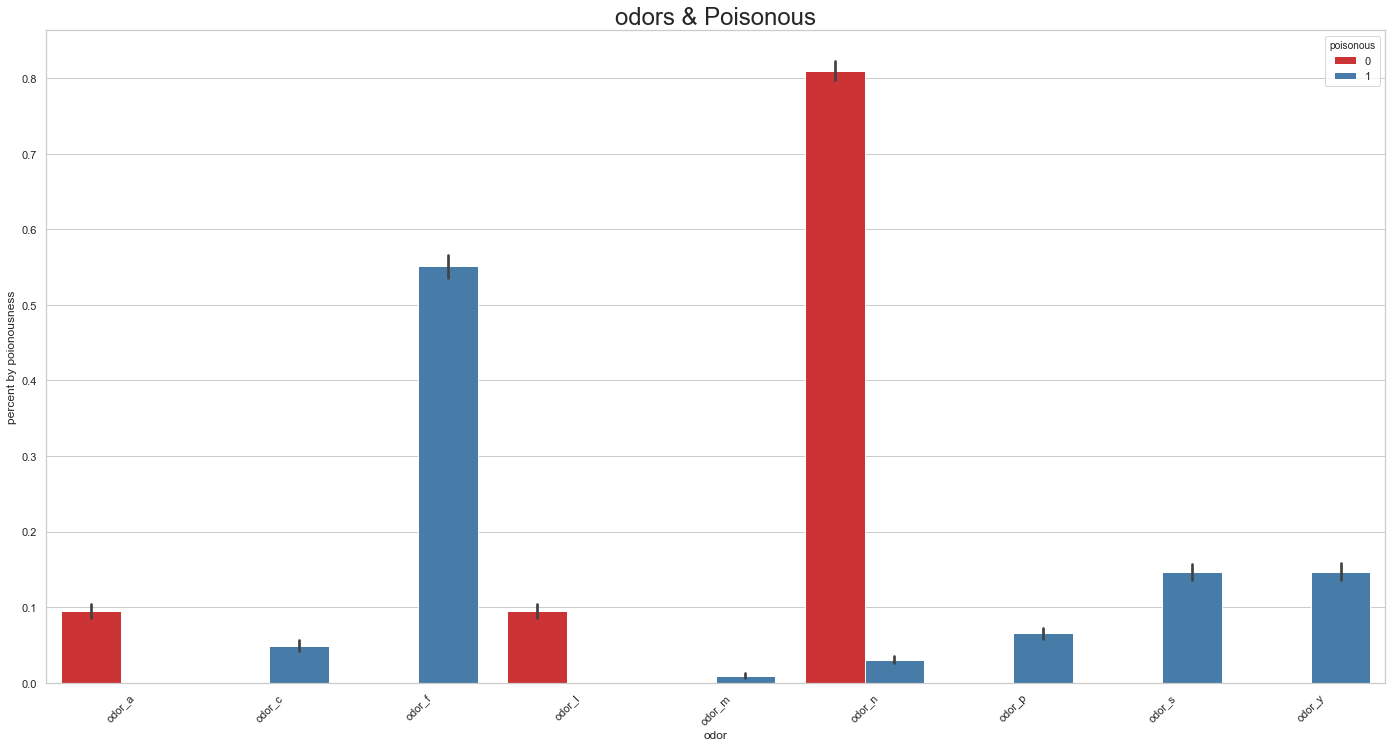

In [34]:
plt.figure(figsize=(24,12));
sns.set(style='whitegrid', palette='deep')
ax = sns.barplot(
    data=df_with_dummies.melt(id_vars=['poisonous','bruises?'],value_vars=df_with_dummies.columns.values[2:11]),
    x='variable',
    y='value',
    hue='poisonous',
    palette= 'Set1').set_title('odors & Poisonous',size=24
    );
plt.xlabel('odor');
plt.ylabel('percent by poionousness')
plt.xticks(rotation=45);

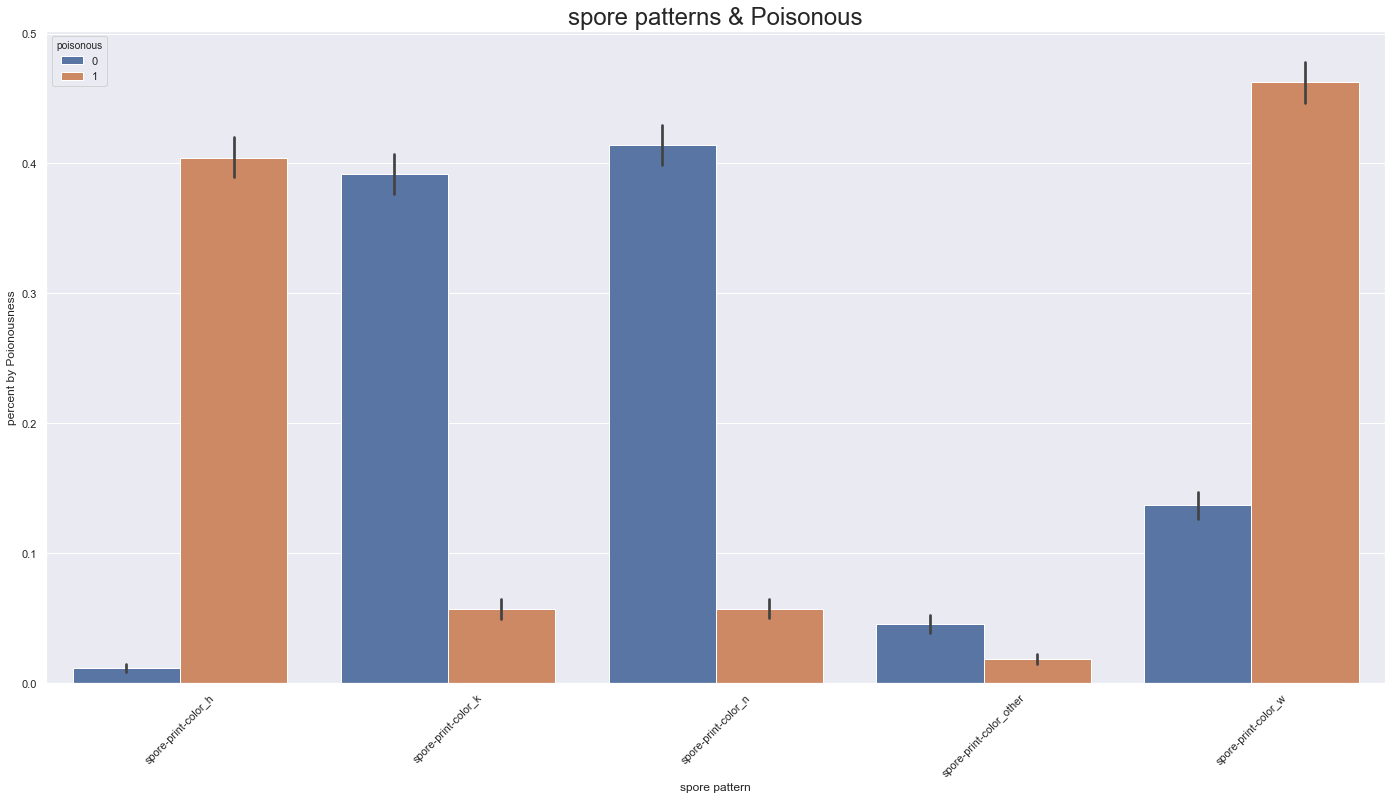

In [26]:
plt.figure(figsize=(24,12));
sns.set()
ax = sns.barplot(
    data=df_with_dummies.melt(id_vars=['poisonous','bruises?'],value_vars=df_with_dummies.columns.values[11:]),
    x='variable',
    y='value',
    hue='poisonous',
    ).set_title('spore patterns & Poisonous',size=24);
plt.xticks(rotation=45);
plt.xlabel('spore pattern');
plt.ylabel('percent by Poionousness');

### conclusions:

____

# phase 2: : Build Predictive Models


In [80]:
# load the LogisticRegression and metrics functions
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
# set y_train varible with poisonous 
y_train = df_with_dummies.poisonous.values
# set a predictors varible starting with all varibles 
predictors = df_with_dummies.columns.values[1:]
#set a x_train varible 
X_train = df_with_dummies[predictors].values

#sanity check x_train
X_train[:5]


array([[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]], dtype=int32)

In [64]:
#saniy check Y_train
y_train[:5]

array([1, 0, 0, 1, 0])

## null error rate

In [75]:
df_for_pred.poisonous.sum()/df_for_pred.shape[0]

0.48202855736090594

In [71]:
# initialize a Logistic 
model = LogisticRegression(solver = 'lbfgs')
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [72]:
model.score(X_train,y_train)

0.9852289512555391

In [141]:
for e,p in enumerate(predictors):
    print(f'{p} = {model.coef_[0][e]}')
    

bruises? = 0.9845965282309062
odor_a = -6.370764481090044
odor_c = 4.420225157911981
odor_f = 3.76038211006417
odor_l = -6.370764481090044
odor_m = 0.9214413785275798
odor_n = -5.538748545635588
odor_p = 3.86546193244749
odor_s = 2.655848383087907
odor_y = 2.65584838308791
spore-print-color_h = 0.83220191234103
spore-print-color_k = -2.2578961444188193
spore-print-color_n = -2.2760811411417
spore-print-color_other = 2.5765869553793483
spore-print-color_w = 1.124118255151537


In [111]:
y_pred = model.predict(X_train)
y_pred[:5]

array([1, 0, 0, 1, 0])

In [131]:
print(metrics.classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      4208
           1       1.00      0.97      0.98      3916

   micro avg       0.99      0.99      0.99      8124
   macro avg       0.99      0.98      0.99      8124
weighted avg       0.99      0.99      0.99      8124

